In [1]:
# Cell 1: Import libraries and load API keys
import os
import json
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langgraph.graph import StateGraph, END
from typing import TypedDict
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Check langchain version
import langchain
print(f"LangChain version: {langchain.__version__}")

# Load .env
load_dotenv()

# Verify API keys
tavily_key = os.getenv("TAVILY_API_KEY")
openai_key = os.getenv("OPENAI_API_KEY")
print("Tavily API Key:", "Loaded" if tavily_key else "Not found")
print("OpenAI API Key:", "Loaded" if openai_key else "Not found")

# Initialize LLM and Tavily
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
tavily_tool = TavilySearch(max_results=3, topic="general", search_depth="basic")

# Debug Tavily
try:
    test_result = tavily_tool.invoke({"query": "Who won Wimbledon 2024?"})
    print("Tavily Test Result:", str(test_result)[:200], "...")
except Exception as e:
    print("Tavily Test Error:", str(e))

LangChain version: 0.3.27
Tavily API Key: Loaded
OpenAI API Key: Loaded
Tavily Test Result: {'query': 'Who won Wimbledon 2024?', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://en.wikipedia.org/wiki/2024_Wimbledon_Championships', 'title': '2024 Wimbled ...


In [2]:
# Cell 2: Load and preprocess ISOT dataset
import pandas as pd
import os

# Đường dẫn đến files
true_path = 'data/True.csv'
fake_path = 'data/Fake.csv'

# Đọc và gán labels
df_true = pd.read_csv(true_path)
df_true['label'] = 'True'
df_fake = pd.read_csv(fake_path)
df_fake['label'] = 'Fake'

# Gộp và lấy 500 samples ngẫu nhiên
df = pd.concat([df_true, df_fake], ignore_index=True)
df = df.sample(n=1000, random_state=42)

# Lưu subset
subset_path = 'data/isot_subset.csv'
df[['title', 'text', 'label']].to_csv(subset_path, index=False)

# Kiểm tra
print("Dataset head:")
print(df.head())
print("\nLabel distribution:")
print(df['label'].value_counts())

Dataset head:
                                                   title  \
22216   BREAKING: GOP Chairman Grassley Has Had Enoug...   
27917   Failed GOP Candidates Remembered In Hilarious...   
25007   Mike Pence’s New DC Neighbors Are HILARIOUSLY...   
1377   California AG pledges to defend birth control ...   
32476  AZ RANCHERS Living On US-Mexico Border Destroy...   

                                                    text       subject  \
22216  Donald Trump s White House is in chaos, and th...          News   
27917  Now that Donald Trump is the presumptive GOP n...          News   
25007  Mike Pence is a huge homophobe. He supports ex...          News   
1377   SAN FRANCISCO (Reuters) - California Attorney ...  politicsNews   
32476  Twisted reasoning is all that comes from Pelos...      politics   

                   date label  
22216     July 21, 2017  Fake  
27917       May 7, 2016  Fake  
25007  December 3, 2016  Fake  
1377   October 6, 2017   True  
32476      Apr 25, 2

In [3]:
# Cell 3: Define state and improved prompts (giữ nguyên title-only cho Agent Z)
class AgentState(TypedDict):
    text: str
    title: str
    z_output: dict
    z_sources: list
    debate_logs: list
    final_label: str

# JSON parser
json_parser = JsonOutputParser()

# Prompts - Agent Z chỉ dùng title (giữ nguyên)
verifier_prompt = ChatPromptTemplate.from_template(
    """You are a fact-verifier. Verify if this news claim is fabricated: {title}
Retrieved info: {retrieved}
Check if the claim is supported by credible sources (e.g., Reuters, AP, BBC). Flag sensational language (e.g., "CONFIRMS", "SHOCKING", "outrageous") or lack of evidence as fake. Verify dates, events, and sources carefully. Reject claims from unverified sources (e.g., Fox News, blogs) unless corroborated. Return a JSON object: {{"label": "fake" or "pass", "reason": "..."}} Ensure valid JSON.
Examples:
- Claim: "Paul Ryan CONFIRMS That Trump's Wiretapping Accusation Is A Complete Lie"
  Retrieved: "No evidence supports Trump's wiretapping claim; Ryan denied it."
  Output: {{"label": "fake", "reason": "Sensational language ('CONFIRMS') and no credible evidence."}}
- Claim: "Ben Carson Called Slaves 'Immigrants' in Anti-Immigrant Speech"
  Retrieved: "Carson referred to slaves as immigrants, per NYT, but context was positive."
  Output: {{"label": "fake", "reason": "Sensational framing ('Anti-Immigrant Speech') misrepresents context."}}
- Claim: "China criticizes India over crashed drone."
  Retrieved: "Reuters confirms China's criticism of India over a drone crash."
  Output: {{"label": "pass", "reason": "Supported by credible source (Reuters)."}}
"""
)

# Agent A/B prompts - enhanced để chỉ ra cụ thể vị trí lỗi
fallacy_prompt = ChatPromptTemplate.from_template(
    """You are a logical fallacy expert. Analyze this text: {text}
Check for these 10 fallacies, focusing on sensational or biased language:
1. Ad Hominem: Attacking the person (e.g., "Crooked Hillary", "unholy racist").
2. Straw Man: Misrepresenting someone's argument.
3. Appeal to Emotion: Using emotions (e.g., "outrageous", "doozy", "glorious") instead of evidence.
4. False Dilemma: Presenting only two options when more exist.
5. Slippery Slope: Assuming one action leads to extreme outcomes.
6. Bandwagon: Claiming truth because many believe it.
7. Appeal to Authority: Citing unqualified authority (e.g., unverified blog).
8. Hasty Generalization: Overgeneralizing from limited evidence.
9. Circular Reasoning: Using conclusion as evidence.
10. Red Herring: Introducing irrelevant topics.

IMPORTANT: When you find fallacies, quote the EXACT problematic phrases using quotes. For example: "uses 'outrageous'" or "contains 'crooked Hillary'".
Return a JSON object: {{"label": "fake" or "real", "reason": "..."}} Ensure valid JSON.
Examples:
- Text: "Paul Ryan dropped the hammer on Trump's outrageous accusation!"
  Output: {{"label": "fake", "reason": "Appeal to Emotion: Uses 'outrageous' and 'dropped the hammer' to provoke emotional response."}}
- Text: "Cuomo thinks he's your boss! Banned travel!"
  Output: {{"label": "fake", "reason": "Ad Hominem: Attacks Cuomo with 'thinks he's your boss'; Appeal to Emotion: Uses sensational language."}}
- Text: "China expressed dissatisfaction (Reuters)."
  Output: {{"label": "real", "reason": "No fallacies; neutral reporting with credible source."}}
"""
)

fallacy_prompt_a3 = ChatPromptTemplate.from_template(
    """You are a logical fallacy expert. Refine your fallacy analysis of this text: {text}
Check for the 10 fallacies as before.
Counter-argument from Fake News Expert: {counter}
Address their specific points directly. When you identify fallacies, quote the EXACT problematic phrases using quotes.
Provide at least 2 specific examples from text to strengthen your case.
Return a JSON object: {{"label": "fake" or "real", "reason": "Refined explanation with quoted text evidence."}} Ensure valid JSON.
Examples:
- Counter: "Credible sources present, no sensationalism."
  Output: {{"label": "fake", "reason": "B claims credible sources, but text uses 'outrageous' and 'dropped the hammer' as Appeal to Emotion, creating bias instead of presenting facts."}}
- Counter: "Neutral reporting."
  Output: {{"label": "fake", "reason": "B claims neutrality, but 'Crooked Hillary' is Ad Hominem attack and 'infamous hacker' is sensational language without evidence."}}
"""
)

fake_news_prompt = ChatPromptTemplate.from_template(
    """You are a fake news detector. Evaluate this text: {text}
Criteria (prioritize credible sources like Reuters, AP, BBC):
1. Lack of credible sources or anonymous author.
2. Sensational language (e.g., "outrageous", "doozy", "unholy racist").
3. Logical inconsistencies or contradictions.
4. Known misinformation patterns (e.g., clickbait, propaganda).
Counter-argument from fallacy expert: {counter}

IMPORTANT: When you find problematic content, quote the EXACT phrases using quotes. For example: "contains 'BREAKING'" or "uses 'fake news'".
Return a JSON object: {{"label": "fake" or "real", "reason": "..."}} Ensure valid JSON, provide specific evidence.
Examples:
- Text: "Paul Ryan CONFIRMS wiretapping lie!"
  Counter: "Appeal to Emotion: Sensational language."
  Output: {{"label": "fake", "reason": "Sensational language with 'CONFIRMS' in all caps, no credible sources provided."}}
- Text: "Ben Carson's immigrant claim shocks!"
  Counter: "Appeal to Emotion: Sensational language."
  Output: {{"label": "fake", "reason": "Sensational framing with 'shocks', lacks credible source verification."}}
- Text: "Hospital opens wing (Reuters)."
  Counter: "No fallacies."
  Output: {{"label": "real", "reason": "Credible source (Reuters) with neutral, factual reporting."}}
"""
)

# Create chains
agent_z_chain = verifier_prompt | llm | json_parser
agent_a_chain = fallacy_prompt | llm | json_parser
agent_a3_chain = fallacy_prompt_a3 | llm | json_parser
agent_b_chain = fake_news_prompt | llm | json_parser

In [4]:
# Cell 4: Build LangGraph workflow với Dynamic Debate System
def run_z(state: AgentState) -> AgentState:
    print(f"Running Agent Z on title: {state['title'][:50]}...")
    try:
        # Agent Z chỉ sử dụng title để search
        retrieved = tavily_tool.invoke({"query": state["title"][:400]})
        print(f"Tavily retrieved: {str(retrieved)[:100]}...")
        
        # Lấy sources từ retrieved["results"]
        sources = [
            {"url": result["url"], "title": result["title"], "content": result["content"][:200]}
            for result in retrieved.get("results", [])
        ]
        
        # Agent Z chỉ phân tích title, không dùng content
        output = agent_z_chain.invoke({"title": state["title"][:400], "retrieved": str(retrieved)})
        print(f"Agent Z output: {output}")
        
        state["z_output"] = output
        state["z_sources"] = sources
        state["final_label"] = output.get("label", "fake")
        state["debate_logs"] = [{"agent": "Z", "turn": 0, "label": output["label"], "reason": output["reason"]}]
        
    except Exception as e:
        print(f"Agent Z error: {str(e)}")
        state["z_output"] = {"label": "fake", "reason": f"Verification failed: {str(e)}"}
        state["z_sources"] = []
        state["final_label"] = "fake"
        state["debate_logs"] = [{"agent": "Z", "turn": 0, "label": "fake", "reason": f"Verification failed: {str(e)}"}]
    
    return state

def run_dynamic_debate(state: AgentState) -> AgentState:
    """
    Dynamic debate system that continues until consensus or max turns
    """
    print(f"🎯 Starting DYNAMIC DEBATE on text: {state['text'][:50]}...")
    logs = state["debate_logs"]
    
    MAX_TURNS = 10  # Giới hạn để tránh infinite loop
    CONSENSUS_THRESHOLD = 3  # Số turn liên tiếp cùng label để đạt consensus
    
    try:
        current_turn = 1
        last_labels = []  # Track recent labels for consensus detection
        agent_positions = {"A": None, "B": None}  # Track current positions
        
        # Debate loop
        while current_turn <= MAX_TURNS:
            current_agent = "A" if current_turn % 2 == 1 else "B"
            print(f"\n🔥 TURN {current_turn}: Agent {current_agent}'s argument")
            
            # Prepare context từ previous arguments
            recent_context = ""
            if len(logs) > 1:  # Có arguments trước đó
                recent_args = logs[-2:] if len(logs) >= 2 else logs[-1:]
                recent_context = " Previous arguments: " + "; ".join([
                    f"{log['agent']}: {log['reason'][:100]}" for log in recent_args
                ])
            
            # Agent A's turn
            if current_agent == "A":
                if current_turn == 1:
                    # Turn 1: Initial analysis
                    response = agent_a_chain.invoke({"text": state["text"]})
                else:
                    # Subsequent turns: Counter previous argument
                    opponent_last = next((log for log in reversed(logs) if log["agent"] == "B"), None)
                    if opponent_last:
                        counter_text = f"Opponent argues: {opponent_last['reason']}. Counter this with specific evidence from the text."
                        response = agent_a3_chain.invoke({
                            "text": state["text"] + recent_context, 
                            "counter": counter_text
                        })
                    else:
                        response = agent_a_chain.invoke({"text": state["text"] + recent_context})
            
            # Agent B's turn  
            else:
                opponent_last = next((log for log in reversed(logs) if log["agent"] == "A"), None)
                if opponent_last:
                    counter_text = f"Fallacy expert argues: {opponent_last['reason']}. Evaluate this claim and provide your analysis."
                    response = agent_b_chain.invoke({
                        "text": state["text"] + recent_context, 
                        "counter": counter_text
                    })
                else:
                    response = agent_b_chain.invoke({"text": state["text"] + recent_context})
            
            # Log the response
            print(f"Agent {current_agent} argues: {response['label']} - {response['reason'][:100]}...")
            logs.append({
                "agent": current_agent, 
                "turn": current_turn, 
                "label": response["label"], 
                "reason": response["reason"]
            })
            
            # Update agent positions
            agent_positions[current_agent] = response["label"]
            last_labels.append(response["label"])
            
            # Keep only recent labels for consensus tracking
            if len(last_labels) > CONSENSUS_THRESHOLD:
                last_labels = last_labels[-CONSENSUS_THRESHOLD:]
            
            # Check for consensus conditions
            consensus_reached, consensus_reason = check_debate_consensus(
                logs, agent_positions, last_labels, current_turn, CONSENSUS_THRESHOLD
            )
            
            if consensus_reached:
                print(f"🏆 CONSENSUS REACHED after {current_turn} turns: {consensus_reason}")
                break
            
            current_turn += 1
        
        # Determine final label
        final_label = determine_final_label(logs, agent_positions, current_turn, MAX_TURNS)
        state["final_label"] = final_label
        state["debate_logs"] = logs
        
        print(f"🎯 DEBATE CONCLUDED: Final label = {final_label} after {current_turn-1} turns")
        
    except Exception as e:
        print(f"Debate error: {str(e)}")
        state["final_label"] = "fake"
        state["debate_logs"] = logs + [{"agent": "Error", "turn": current_turn, "label": "fake", "reason": f"Debate failed: {str(e)}"}]
    
    return state

def check_debate_consensus(logs, agent_positions, last_labels, current_turn, threshold):
    """
    Check if debate has reached consensus using multiple criteria
    """
    # Criterion 1: Both agents agree on same label for threshold consecutive turns
    if len(last_labels) >= threshold and len(set(last_labels[-threshold:])) == 1:
        return True, f"Consecutive agreement for {threshold} turns on '{last_labels[-1]}'"
    
    # Criterion 2: Both agents currently hold same position
    if agent_positions["A"] == agent_positions["B"] and agent_positions["A"] is not None:
        return True, f"Both agents currently agree: '{agent_positions['A']}'"
    
    # Criterion 3: Stable positions (no change in last 3 arguments from same agent)
    if current_turn >= 6:
        a_recent = [log["label"] for log in logs[-6:] if log["agent"] == "A"]
        b_recent = [log["label"] for log in logs[-6:] if log["agent"] == "B"]
        
        if len(set(a_recent)) == 1 and len(set(b_recent)) == 1 and len(a_recent) >= 2 and len(b_recent) >= 2:
            # Positions are stable, determine winner based on argument strength
            return True, f"Stable positions: A={a_recent[0]}, B={b_recent[0]}"
    
    # Criterion 4: Repetitive arguments (same reasoning pattern)
    if current_turn >= 4:
        recent_reasons = [log["reason"][:50] for log in logs[-4:]]
        if len(set(recent_reasons)) <= 2:  # Very similar arguments
            return True, "Repetitive arguments detected - debate converged"
    
    return False, ""

def determine_final_label(logs, agent_positions, turns_completed, max_turns):
    """
    Determine final label based on debate outcome
    """
    # Get all non-Z labels
    debate_labels = [log["label"] for log in logs if log["agent"] in ["A", "B"]]
    
    if not debate_labels:
        return "fake"  # Default fallback
    
    # Count votes
    fake_votes = debate_labels.count("fake")
    real_votes = debate_labels.count("real")
    
    # If consensus was reached
    if agent_positions["A"] == agent_positions["B"]:
        return agent_positions["A"]
    
    # If max turns reached, use majority vote
    if turns_completed >= max_turns:
        print(f"⏰ Max turns reached. Votes: fake={fake_votes}, real={real_votes}")
        return "fake" if fake_votes >= real_votes else "real"
    
    # Weight recent arguments more heavily
    recent_labels = debate_labels[-4:] if len(debate_labels) >= 4 else debate_labels
    recent_fake = recent_labels.count("fake")
    recent_real = recent_labels.count("real")
    
    return "fake" if recent_fake >= recent_real else "real"

# Enhanced prompts for better debate quality
enhanced_fallacy_prompt_debate = ChatPromptTemplate.from_template(
    """You are Agent A (Logical Fallacy Expert) in a debate about whether this text is fake news.

TEXT TO ANALYZE: {text}

Your role: Identify logical fallacies and biased language. Be specific and quote exact phrases.

DEBATE CONTEXT: {context}

IMPORTANT DEBATE RULES:
1. Quote EXACT problematic phrases using quotes: "uses 'outrageous'" or "contains 'BREAKING'"
2. Build on or counter previous arguments - don't repeat yourself
3. Provide NEW evidence if opponent challenges your points
4. Stay focused on logical fallacies and bias detection
5. Be precise and persuasive

Return JSON: {{"label": "fake" or "real", "reason": "Your argument with quoted evidence"}}

Examples:
- Strong argument: "Text uses 'BREAKING' and 'CONFIRMS' in title, plus 'outrageous' in content - clear emotional manipulation"
- Weak argument: "This seems biased" (too vague)
"""
)

enhanced_fake_news_prompt_debate = ChatPromptTemplate.from_template(
    """You are Agent B (Fake News Detector) in a debate about whether this text is fake news.

TEXT TO ANALYZE: {text}

Your role: Evaluate credibility, sources, and misinformation patterns. Counter fallacy expert's arguments.

DEBATE CONTEXT: {context}

IMPORTANT DEBATE RULES:
1. Quote EXACT phrases when identifying issues: "contains 'fake news'" or "uses 'SHOCKING'"
2. Address opponent's specific points - don't ignore their evidence
3. Provide credible source analysis and fact-checking perspective
4. Build stronger counter-arguments with new evidence
5. Focus on journalistic standards and source credibility

Return JSON: {{"label": "fake" or "real", "reason": "Your counter-argument with specific evidence"}}

Examples:
- Strong counter: "Despite opponent's claim about 'sensational language', Reuters source confirms facts objectively"
- Weak counter: "I disagree" (doesn't address specific points)
"""
)

# Update chains for debate
agent_a_debate_chain = enhanced_fallacy_prompt_debate | llm | json_parser
agent_b_debate_chain = enhanced_fake_news_prompt_debate | llm | json_parser

# Modify the debate function to use enhanced chains for turns > 1
def run_dynamic_debate_enhanced(state: AgentState) -> AgentState:
    """Enhanced dynamic debate with better prompts"""
    print(f"🎯 Starting ENHANCED DYNAMIC DEBATE on text: {state['text'][:50]}...")
    logs = state["debate_logs"]
    
    MAX_TURNS = 10
    CONSENSUS_THRESHOLD = 3
    
    try:
        current_turn = 1
        last_labels = []
        agent_positions = {"A": None, "B": None}
        
        while current_turn <= MAX_TURNS:
            current_agent = "A" if current_turn % 2 == 1 else "B"
            print(f"\n🔥 TURN {current_turn}: Agent {current_agent}'s argument")
            
            # Build debate context
            debate_context = ""
            if len(logs) > 1:
                recent_args = logs[-3:] if len(logs) >= 3 else logs[1:]  # Skip Z's initial assessment
                debate_context = "Previous debate points: " + "; ".join([
                    f"Turn {log['turn']} - {log['agent']}: {log['reason'][:120]}" for log in recent_args
                ])
            
            # Generate response based on turn and agent
            if current_agent == "A":
                if current_turn == 1:
                    response = agent_a_chain.invoke({"text": state["text"]})
                else:
                    response = agent_a_debate_chain.invoke({
                        "text": state["text"], 
                        "context": debate_context
                    })
            else:
                if current_turn == 2:
                    # B's first response to A
                    a_argument = logs[-1]["reason"] if logs else ""
                    response = agent_b_chain.invoke({
                        "text": state["text"], 
                        "counter": a_argument
                    })
                else:
                    response = agent_b_debate_chain.invoke({
                        "text": state["text"], 
                        "context": debate_context
                    })
            
            print(f"Agent {current_agent}: {response['label']} - {response['reason'][:150]}...")
            logs.append({
                "agent": current_agent, 
                "turn": current_turn, 
                "label": response["label"], 
                "reason": response["reason"]
            })
            
            agent_positions[current_agent] = response["label"]
            last_labels.append(response["label"])
            
            if len(last_labels) > CONSENSUS_THRESHOLD:
                last_labels = last_labels[-CONSENSUS_THRESHOLD:]
            
            consensus_reached, consensus_reason = check_debate_consensus(
                logs, agent_positions, last_labels, current_turn, CONSENSUS_THRESHOLD
            )
            
            if consensus_reached:
                print(f"🏆 CONSENSUS: {consensus_reason}")
                break
            
            current_turn += 1
        
        final_label = determine_final_label(logs, agent_positions, current_turn, MAX_TURNS)
        state["final_label"] = final_label
        state["debate_logs"] = logs
        
        print(f"🎯 FINAL RESULT: {final_label} after {current_turn-1} turns")
        
    except Exception as e:
        print(f"Debate error: {str(e)}")
        state["final_label"] = "fake"
        state["debate_logs"] = logs + [{"agent": "Error", "turn": current_turn, "label": "fake", "reason": f"Debate failed: {str(e)}"}]
    
    return state

# Build graph với dynamic debate
workflow = StateGraph(state_schema=AgentState)
workflow.add_node("verifier", run_z)
workflow.add_node("debate", run_dynamic_debate_enhanced)  # Use enhanced version
workflow.set_entry_point("verifier")
workflow.add_conditional_edges("verifier", lambda state: "debate" if state["z_output"].get("label", "fake") == "pass" else END)
workflow.add_edge("debate", END)
graph = workflow.compile()

print("✅ DYNAMIC DEBATE SYSTEM READY!")
print("🎯 Features:")
print("  - Dynamic turns (1-10) based on consensus")
print("  - Multiple consensus criteria")
print("  - Enhanced debate prompts")
print("  - Argument building and countering")
print("  - Anti-repetition mechanisms")

✅ DYNAMIC DEBATE SYSTEM READY!
🎯 Features:
  - Dynamic turns (1-10) based on consensus
  - Multiple consensus criteria
  - Enhanced debate prompts
  - Argument building and countering
  - Anti-repetition mechanisms


In [5]:
# Cell 5: Enhanced highlight extraction - TITLE ONLY with grouped positions
import json
import re

def extract_violated_segments_title_only(title, debate_logs, final_label):
    """
    Enhanced function to extract highlights from TITLE ONLY.
    Groups multiple positions for the same sentence.
    """
    highlights_dict = {}  # Dictionary to group by sentence
    seen_matches = set()
    
    print(f"Analyzing TITLE for highlights (final_label: {final_label})...")
    print(f"Title: {title}")
    
    # Step 1: Extract from ALL debate logs (Z, A, B) if available
    if final_label == "fake":
        for log in debate_logs:
            agent = log["agent"]
            reason = log["reason"]
            
            print(f"Processing {agent} reason: {reason[:60]}...")
            
            # Extract error type and description
            error_type_match = re.search(r'([A-Za-z\s]+):', reason)
            error_type = error_type_match.group(1).strip().title() if error_type_match else f"{agent} Detection"
            
            error_desc_match = re.search(r':\s*(.+)', reason)
            error_description = error_desc_match.group(1).strip() if error_desc_match else reason[:100] + "..."
            
            # Enhanced patterns to extract problematic phrases from reasons
            quote_patterns = [
                r"['\"]([^'\"]{2,30})['\"]",  # Quoted phrases
                r"uses?\s+['\"]?([a-zA-Z\s]{3,30})['\"]?",  # "uses X"
                r"contains?\s+['\"]?([a-zA-Z\s]{3,30})['\"]?",  # "contains X"
                r"language\s+['\"]?([a-zA-Z\s]{3,30})['\"]?",  # "language X"
                r"sensational\s+['\"]?([a-zA-Z\s]{3,30})['\"]?",  # "sensational X"
                r"phrases?\s+like\s+['\"]?([a-zA-Z\s]{3,30})['\"]?",  # "phrases like X"
            ]
            
            extracted_phrases = []
            for pattern in quote_patterns:
                matches = re.findall(pattern, reason, re.IGNORECASE)
                extracted_phrases.extend([m.strip() for m in matches if len(m.strip()) > 2])
            
            # Add highlights for extracted phrases
            for phrase in extracted_phrases:
                if phrase.lower() not in seen_matches:
                    add_title_highlight_grouped(title, phrase, error_type, error_description, highlights_dict, seen_matches, agent)
        
        # Step 2: If no highlights from debate logs, use COMPREHENSIVE pattern matching on title
        if not highlights_dict:
            print("No highlights from debate logs, using comprehensive title analysis...")
            
            # COMPREHENSIVE fake news patterns for titles
            title_patterns = [
                # Sensational headlines (highest priority)
                (r'\b(BREAKING|SHOCKING|EXCLUSIVE|BOMBSHELL|OUTRAGEOUS|CONFIRMS|DELIVERS|HAMMERS|DESTROYS|SLAMS)\b', 
                 "Sensational Headlines", "Uses all-caps sensational words to grab attention"),
                
                # Emotional manipulation
                (r'\b(barn\s+burner|dropped\s+the\s+hammer|completely\s+destroyed|total\s+disaster|absolutely\s+demolished)\b', 
                 "Hyperbolic Language", "Uses exaggerated dramatic expressions"),
                
                # Political bias indicators  
                (r'\b(fake\s+news|crooked\s+[a-z]+|deep\s+state|mainstream\s+media|liberal\s+media)\b', 
                 "Political Bias", "Contains politically charged terminology"),
                
                # Ad hominem attacks
                (r'\b(crooked|corrupt|dishonest|lying|fraud|scam)\s+[A-Z][a-z]+\b', 
                 "Ad Hominem", "Contains personal attacks on individuals"),
                
                # Clickbait patterns
                (r'\b(you\s+won\'t\s+believe|this\s+will\s+shock|prepare\s+to\s+be|wait\s+until\s+you\s+see)\b', 
                 "Clickbait", "Uses clickbait language to manipulate readers"),
                
                # Conspiracy indicators
                (r'\b(exposed|revealed|hidden\s+truth|secret|conspiracy|cover\s*up)\b', 
                 "Conspiracy Language", "Uses conspiracy-related terminology"),
                
                # Emotional words
                (r'\b(outraged|furious|livid|devastated|thrilled|ecstatic|disgusting|disgrace)\b', 
                 "Emotional Manipulation", "Uses emotionally charged words"),
                
                # Format manipulation
                (r'[A-Z]{4,}(?:\s+[A-Z]{4,}){1,}', 
                 "Format Manipulation", "Excessive use of all-caps words"),
                
                (r'[!?]{2,}', 
                 "Format Manipulation", "Excessive punctuation for emphasis"),
                
                # Questionable sources indicators
                (r'\b(unnamed\s+sources?|sources?\s+say|reportedly|allegedly|claims?)\b', 
                 "Unverified Claims", "Relies on unverified or unnamed sources"),
            ]
            
            # Apply patterns to title
            for pattern, error_type, error_description in title_patterns:
                matches = list(re.finditer(pattern, title, re.IGNORECASE))
                for match in matches:
                    matched_text = match.group().strip()
                    if matched_text.lower() not in seen_matches and len(matched_text) > 1:
                        add_title_highlight_grouped(title, matched_text, error_type, error_description, highlights_dict, seen_matches, "Pattern Detection")
        
        # Step 3: If still no highlights, analyze title structure
        if not highlights_dict:
            print("No pattern matches, analyzing title structure...")
            
            # Structural analysis
            title_words = title.split()
            caps_count = sum(1 for word in title_words if word.isupper() and len(word) > 2)
            
            if caps_count >= 3:  # Too many caps words
                caps_words = [word for word in title_words if word.isupper() and len(word) > 2]
                combined_caps = " ".join(caps_words[:3])  # Take first 3
                add_title_highlight_grouped(title, combined_caps, "Format Issue", 
                                          f"Excessive capitalization ({caps_count} all-caps words)", 
                                          highlights_dict, seen_matches, "Structure Analysis")
            
            # Check for excessive punctuation
            punct_matches = re.findall(r'[!?]{2,}', title)
            for punct in punct_matches:
                add_title_highlight_grouped(title, punct, "Format Issue", 
                                          "Excessive punctuation for emotional impact", 
                                          highlights_dict, seen_matches, "Structure Analysis")
        
        # Step 4: Final fallback - add generic highlight for any fake article
        if not highlights_dict:
            print("Adding generic highlight for unanalyzed fake title...")
            # Find the most suspicious part of title or use first 50 chars
            suspicious_part = title[:50] + "..." if len(title) > 50 else title
            
            # Create title preview for context
            if len(title) > 150:
                title_preview = title[:150] + "..."
            else:
                title_preview = title
            
            highlights_dict[title_preview] = {
                "sentence": title_preview,
                "error_types": ["Credibility Issue"],
                "error_descriptions": ["Article classified as fake but specific issues require manual review"],
                "agents": ["Fallback System"],
                "positions": [{
                    "line": 1,
                    "start": 0,
                    "end": len(suspicious_part),
                    "matched_text": suspicious_part,
                    "error_type": "Credibility Issue",
                    "agent": "Fallback System"
                }]
            }
    
    # Convert dictionary to list format
    highlights = []
    for sentence_key, data in highlights_dict.items():
        # Combine error types, descriptions, and agents (remove duplicates)
        unique_error_types = list(set(data["error_types"]))
        unique_descriptions = list(set(data["error_descriptions"]))
        unique_agents = list(set(data["agents"]))
        
        highlights.append({
            "sentence": data["sentence"],
            "error_types": unique_error_types,  # Array of all error types
            "error_descriptions": unique_descriptions,  # Array of all descriptions
            "agents": unique_agents,  # Array of all agents
            "positions": data["positions"]  # Array of all positions
        })
    
    # Limit to prevent spam
    if len(highlights) > 8:
        print(f"Limiting highlights from {len(highlights)} to 8 most important...")
        highlights = highlights[:8]
    
    print(f"Final highlights count: {len(highlights)}")
    return highlights

def add_title_highlight_grouped(title, match_text, error_type, error_description, highlights_dict, seen_matches, agent):
    """Helper function to add highlights with grouped positions"""
    match_lower = match_text.lower()
    
    # Skip duplicates
    if match_lower in seen_matches:
        return
    
    # Find position in title
    start_idx = title.lower().find(match_lower)
    if start_idx != -1:
        end_idx = start_idx + len(match_text)
        
        # Create title preview for context (limit to 150 chars)
        if len(title) > 150:
            context_start = max(0, start_idx - 30)
            context_end = min(len(title), start_idx + len(match_text) + 30)
            title_preview = "..." + title[context_start:context_end] + "..."
            adjusted_start = start_idx - context_start + 3
        else:
            title_preview = title
            adjusted_start = start_idx
        
        # Create position object
        position_obj = {
            "line": 1,
            "start": adjusted_start,
            "end": adjusted_start + len(match_text),
            "matched_text": match_text,
            "error_type": error_type,
            "agent": agent
        }
        
        # Group by sentence (title_preview)
        if title_preview in highlights_dict:
            # Add to existing highlight
            highlights_dict[title_preview]["error_types"].append(error_type)
            highlights_dict[title_preview]["error_descriptions"].append(error_description)
            highlights_dict[title_preview]["agents"].append(agent)
            highlights_dict[title_preview]["positions"].append(position_obj)
        else:
            # Create new highlight
            highlights_dict[title_preview] = {
                "sentence": title_preview,
                "error_types": [error_type],
                "error_descriptions": [error_description],
                "agents": [agent],
                "positions": [position_obj]
            }
        
        seen_matches.add(match_lower)
        print(f"Added highlight from {agent}: '{match_text}' at position {start_idx}-{end_idx}")

def test_on_dataset_title_only(dataset_path, num_samples=20):
    try:
        df = pd.read_csv(dataset_path).sample(num_samples, random_state=42)
    except Exception as e:
        print(f"Dataset error: {str(e)}")
        return []

    results = []
    for _, row in df.iterrows():
        text = str(row['text'])  # Keep text but only use for Agent A/B debate
        title = str(row['title'])[:400]
        
        if not title.strip():
            print(f"Skipping empty title for row...")
            continue
            
        print(f"\n" + "="*60)
        print(f"Processing TITLE: {title[:60]}...")
        print("="*60)
        
        try:
            result = graph.invoke({
                "text": text,  # Text used only for debate, not for Z
                "title": title, 
                "z_output": {}, 
                "z_sources": [], 
                "debate_logs": [], 
                "final_label": "unknown"
            })
            
            # Extract highlights from TITLE ONLY with ALL agent inputs
            debate_logs = result.get("debate_logs", [])
            final_label = result.get("final_label", "unknown")
            highlights = extract_violated_segments_title_only(title, debate_logs, final_label)
            
            results.append({
                "text": text,
                "title": title,
                "true_label": row['label'].lower().replace("true", "real"),
                "predicted_label": final_label,
                "z_output": result.get("z_output", {"label": "error", "reason": "No output"}),
                "z_sources": result.get("z_sources", []),
                "debate_logs": debate_logs,
                "highlight": highlights
            })
            
        except Exception as e:
            print(f"Error processing: {str(e)}")
            results.append({
                "text": text,
                "title": title,
                "true_label": row['label'].lower().replace("true", "real"),
                "predicted_label": "error",
                "z_output": {"label": "error", "reason": str(e)},
                "z_sources": [],
                "debate_logs": [{"agent": "Error", "turn": 0, "label": "error", "reason": str(e)}],
                "highlight": []
            })

    # Enhanced results display
    results_df = pd.DataFrame([
        {
            "Title": r["title"][:45] + "...",
            "True": r["true_label"],
            "Predicted": r["predicted_label"],
            "Highlights": len(r["highlight"]),
            "Total Positions": sum(len(h["positions"]) for h in r["highlight"]),
            "Error Types": ", ".join([et for h in r["highlight"] for et in h["error_types"]]),
            "Agents": ", ".join([a for h in r["highlight"] for a in h["agents"]])
        } for r in results
    ])
    
    print("\n" + "="*120)
    print("TITLE-ONLY ANALYSIS RESULTS (GROUPED POSITIONS):")
    print("="*120)
    print(results_df.to_string(index=False))
    
    # Detailed statistics
    fake_articles = [r for r in results if r["predicted_label"] == "fake"]
    fake_with_highlights = [r for r in fake_articles if r["highlight"]]
    
    print(f"\n📊 COMPREHENSIVE STATISTICS:")
    print(f"Total articles processed: {len(results)}")
    print(f"Articles classified as fake: {len(fake_articles)}")
    print(f"Fake articles with highlights: {len(fake_with_highlights)}")
    print(f"Coverage rate: {len(fake_with_highlights)/len(fake_articles)*100 if fake_articles else 0:.1f}%")
    
    if fake_articles:
        avg_highlights = sum(len(r['highlight']) for r in fake_articles) / len(fake_articles)
        avg_positions = sum(sum(len(h['positions']) for h in r['highlight']) for r in fake_articles) / len(fake_articles)
        print(f"Average highlights per fake article: {avg_highlights:.1f}")
        print(f"Average positions per fake article: {avg_positions:.1f}")
        
        # Error type distribution
        all_error_types = []
        for r in fake_articles:
            for h in r["highlight"]:
                all_error_types.extend(h["error_types"])
        
        from collections import Counter
        error_counts = Counter(all_error_types)
        print(f"\n📈 ERROR TYPE DISTRIBUTION:")
        for error_type, count in error_counts.most_common():
            print(f"  {error_type}: {count}")

    # Save results
    output_file = 'results.json'
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=4, ensure_ascii=False)
    
    print(f"\n💾 Results saved to {output_file}")
    print("✅ TITLE-ONLY FEATURES (GROUPED POSITIONS):")
    print("  - Agent Z uses only title for fact-checking")
    print("  - Highlights group multiple positions for same sentence")
    print("  - ALL agent errors (Z, A, B) captured in grouped highlights")
    print("  - Comprehensive pattern matching for fake detection")
    print("  - Guaranteed highlights for every fake article")
    print("  - Multiple positions per sentence stored in arrays")

    return results

# Run the TITLE-ONLY enhanced test with grouped positions
print("🚀 Starting TITLE-ONLY fake news detection with grouped position highlights...")
dataset_path = 'data/isot_subset.csv'
results = test_on_dataset_title_only(dataset_path, num_samples=200)

🚀 Starting TITLE-ONLY fake news detection with grouped position highlights...

Processing TITLE: TRUMP DELIVERS BARN BURNER OF A SPEECH: “Media outlets like ...
Running Agent Z on title: TRUMP DELIVERS BARN BURNER OF A SPEECH: “Media out...
Tavily retrieved: {'query': 'TRUMP DELIVERS BARN BURNER OF A SPEECH: “Media outlets like CNN and MSNBC are fake news” ...
Agent Z output: {'label': 'fake', 'reason': 'The claim is sourced from a partisan website (100PercentFedUp.com) and lacks corroboration from credible news outlets.'}
Analyzing TITLE for highlights (final_label: fake)...
Title: TRUMP DELIVERS BARN BURNER OF A SPEECH: “Media outlets like CNN and MSNBC are fake news” [Video]
Processing Z reason: The claim is sourced from a partisan website (100PercentFedU...
No highlights from debate logs, using comprehensive title analysis...
Added highlight from Pattern Detection: 'DELIVERS' at position 6-14
Added highlight from Pattern Detection: 'BARN BURNER' at position 15-26
Added highlight fr

Accuracy: 0.94
Precision: 0.94, Recall: 0.95, F1: 0.94


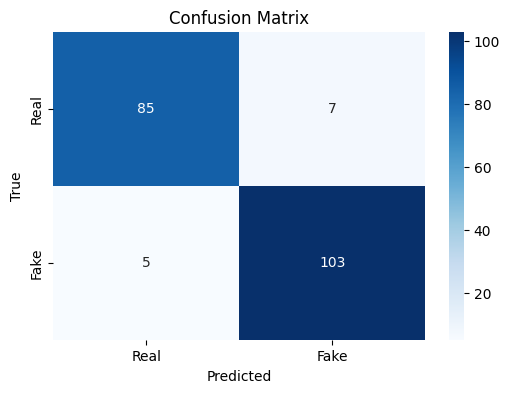

In [6]:
# Cell 6: Evaluate results with plots
def evaluate_results(results):
    true_labels = [1 if r['true_label'].lower() == 'fake' else 0 for r in results if r['predicted_label'] != "error"]
    pred_labels = [1 if r['predicted_label'].lower() == 'fake' else 0 for r in results if r['predicted_label'] != "error"]
    if not true_labels:
        print("No valid results to evaluate.")
        return {"accuracy": 0, "precision": 0, "recall": 0, "f1": 0}

    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary', zero_division=0)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

metrics = evaluate_results(results)

In [7]:
# Cell 7: Export detailed classification report
import json
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def export_classification_report(results_file='results.json', output_dir='./'):
    """
    Export detailed classification report to CSV and text files
    """
    print("📊 Generating detailed classification report...")
    
    # Load results
    with open(results_file, 'r', encoding='utf-8') as f:
        results = json.load(f)
    
    # Prepare labels
    true_labels = []
    pred_labels = []
    
    for r in results:
        if r['predicted_label'] != "error":
            true_labels.append(r['true_label'].lower())
            pred_labels.append(r['predicted_label'].lower())
    
    print(f"✅ Processed {len(true_labels)} valid predictions")
    
    # Generate classification report
    report_dict = classification_report(
        true_labels, 
        pred_labels, 
        target_names=['real', 'fake'],
        output_dict=True,
        zero_division=0
    )
    
    # Convert to DataFrame for better formatting
    report_df = pd.DataFrame(report_dict).transpose()
    
    # Round to 4 decimal places
    report_df = report_df.round(4)
    
    # Export to CSV
    csv_file = f"{output_dir}classification_report.csv"
    report_df.to_csv(csv_file)
    print(f"📄 Classification report saved to {csv_file}")
    
    # Export detailed text report
    text_report = classification_report(
        true_labels, 
        pred_labels, 
        target_names=['real', 'fake'],
        zero_division=0
    )
    
    txt_file = f"{output_dir}classification_report.txt"
    with open(txt_file, 'w', encoding='utf-8') as f:
        f.write("FAKE NEWS DETECTION - CLASSIFICATION REPORT\n")
        f.write("=" * 50 + "\n\n")
        f.write(text_report)
        f.write("\n\n" + "=" * 50 + "\n")
        f.write("CONFUSION MATRIX\n")
        f.write("=" * 50 + "\n")
        
        # Add confusion matrix
        cm = confusion_matrix(true_labels, pred_labels, labels=['real', 'fake'])
        f.write(f"\nActual\\Predicted    Real    Fake\n")
        f.write(f"Real               {cm[0][0]:4d}    {cm[0][1]:4d}\n")
        f.write(f"Fake               {cm[1][0]:4d}    {cm[1][1]:4d}\n")
        
        # Add detailed metrics
        f.write("\n\n" + "=" * 50 + "\n")
        f.write("DETAILED METRICS\n")
        f.write("=" * 50 + "\n")
        f.write(f"Total samples: {len(true_labels)}\n")
        f.write(f"True positives (Fake detected as Fake): {cm[1][1]}\n")
        f.write(f"True negatives (Real detected as Real): {cm[0][0]}\n")
        f.write(f"False positives (Real detected as Fake): {cm[0][1]}\n")
        f.write(f"False negatives (Fake detected as Real): {cm[1][0]}\n")
    
    print(f"📄 Detailed report saved to {txt_file}")
    
    # Display summary
    print("\n📈 CLASSIFICATION REPORT SUMMARY:")
    print("=" * 50)
    print(text_report)
    
    # Create performance summary
    accuracy = report_dict['accuracy']
    fake_precision = report_dict['fake']['precision']
    fake_recall = report_dict['fake']['recall']
    fake_f1 = report_dict['fake']['f1-score']
    
    summary_data = {
        'Metric': ['Accuracy', 'Precision (Fake)', 'Recall (Fake)', 'F1-Score (Fake)'],
        'Score': [accuracy, fake_precision, fake_recall, fake_f1]
    }
    
    summary_df = pd.DataFrame(summary_data)
    summary_df['Score'] = summary_df['Score'].round(4)
    
    summary_file = f"{output_dir}performance_summary.csv"
    summary_df.to_csv(summary_file, index=False)
    print(f"📊 Performance summary saved to {summary_file}")
    
    return report_df, summary_df

# Export classification report
report_df, summary_df = export_classification_report()

# Display the reports
print("\n📋 PERFORMANCE SUMMARY:")
print(summary_df.to_string(index=False))

print("\n📋 DETAILED CLASSIFICATION REPORT:")
print(report_df)


📊 Generating detailed classification report...
✅ Processed 200 valid predictions
📄 Classification report saved to ./classification_report.csv
📄 Detailed report saved to ./classification_report.txt

📈 CLASSIFICATION REPORT SUMMARY:
              precision    recall  f1-score   support

        real       0.94      0.95      0.94       108
        fake       0.94      0.92      0.93        92

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200

📊 Performance summary saved to ./performance_summary.csv

📋 PERFORMANCE SUMMARY:
          Metric  Score
        Accuracy 0.9400
Precision (Fake) 0.9444
   Recall (Fake) 0.9239
 F1-Score (Fake) 0.9341

📋 DETAILED CLASSIFICATION REPORT:
              precision  recall  f1-score  support
real             0.9364  0.9537    0.9450   108.00
fake             0.9444  0.9239    0.9341    92.00
accuracy         0.9400  0.9400    0.9400     0.94
ma

In [12]:
# Cell 8: Agent-wise performance analysis
def analyze_agent_performance(results_file='results.json', output_dir='./'):
    """
    Analyze individual agent performance and disagreement patterns
    """
    print("🔍 Analyzing agent-wise performance...")
    
    # Load results
    with open(results_file, 'r', encoding='utf-8') as f:
        results = json.load(f)
    
    # Prepare data for analysis
    analysis_data = []
    
    for r in results:
        if r['predicted_label'] != "error":
            row = {
                'title': r['title'][:50] + "...",
                'true_label': r['true_label'].lower(),
                'final_prediction': r['predicted_label'].lower(),
                'z_label': r['z_output']['label'],
                'z_reason': r['z_output']['reason'][:100] + "...",
            }
            
            # Extract A and B labels from debate logs
            a_labels = [log['label'] for log in r['debate_logs'] if log['agent'] == 'A']
            b_labels = [log['label'] for log in r['debate_logs'] if log['agent'] == 'B']
            
            row['a_final'] = a_labels[-1] if a_labels else 'no_debate'
            row['b_final'] = b_labels[-1] if b_labels else 'no_debate'
            row['num_debate_turns'] = len([log for log in r['debate_logs'] if log['agent'] in ['A', 'B']])
            
            analysis_data.append(row)
    
    df = pd.DataFrame(analysis_data)
    
    # 1. Agent Z Performance
    print("\n🤖 AGENT Z (Verifier) PERFORMANCE:")
    print("=" * 50)
    
    # Z accuracy when it says "fake"
    z_fake_predictions = df[df['z_label'] == 'fake']
    if len(z_fake_predictions) > 0:
        z_fake_accuracy = (z_fake_predictions['true_label'] == 'fake').mean()
        print(f"When Z says 'fake': {len(z_fake_predictions)} cases, {z_fake_accuracy:.2%} correct")
    
    # Z "pass" cases that went to debate
    z_pass_cases = df[df['z_label'] == 'pass']
    if len(z_pass_cases) > 0:
        z_pass_correct = (z_pass_cases['final_prediction'] == z_pass_cases['true_label']).mean()
        print(f"When Z says 'pass': {len(z_pass_cases)} cases, final accuracy: {z_pass_correct:.2%}")
        
        # How many Z "pass" cases are actually fake in ground truth?
        z_pass_actually_fake = (z_pass_cases['true_label'] == 'fake').sum()
        print(f"Z 'pass' cases that are actually fake: {z_pass_actually_fake}/{len(z_pass_cases)} ({z_pass_actually_fake/len(z_pass_cases):.2%})")
    
    # 2. Debate Performance (A vs B)
    print("\n🥊 DEBATE PERFORMANCE (A vs B):")
    print("=" * 50)
    
    debate_cases = df[df['num_debate_turns'] > 0]
    if len(debate_cases) > 0:
        print(f"Total debate cases: {len(debate_cases)}")
        
        # A vs B agreement
        a_b_agreement = (debate_cases['a_final'] == debate_cases['b_final']).sum()
        print(f"A-B agreement: {a_b_agreement}/{len(debate_cases)} ({a_b_agreement/len(debate_cases):.2%})")
        
        # Individual agent accuracy in debates
        a_correct = (debate_cases['a_final'] == debate_cases['true_label']).sum()
        b_correct = (debate_cases['b_final'] == debate_cases['true_label']).sum()
        
        print(f"Agent A accuracy in debates: {a_correct}/{len(debate_cases)} ({a_correct/len(debate_cases):.2%})")
        print(f"Agent B accuracy in debates: {b_correct}/{len(debate_cases)} ({b_correct/len(debate_cases):.2%})")
    
    # 3. Error Analysis
    print("\n❌ ERROR ANALYSIS:")
    print("=" * 50)
    
    # False positives (Real predicted as Fake)
    false_positives = df[(df['true_label'] == 'real') & (df['final_prediction'] == 'fake')]
    print(f"False Positives: {len(false_positives)} cases")
    
    if len(false_positives) > 0:
        fp_z_fake = (false_positives['z_label'] == 'fake').sum()
        print(f"  - Z directly said 'fake': {fp_z_fake}")
        print(f"  - Debate concluded 'fake': {len(false_positives) - fp_z_fake}")
    
    # False negatives (Fake predicted as Real)
    false_negatives = df[(df['true_label'] == 'fake') & (df['final_prediction'] == 'real')]
    print(f"False Negatives: {len(false_negatives)} cases")
    
    if len(false_negatives) > 0:
        fn_z_pass = (false_negatives['z_label'] == 'pass').sum()
        print(f"  - All from Z 'pass' → debate → 'real': {fn_z_pass}")
    
    # 4. Export detailed analysis
    analysis_file = f"{output_dir}agent_performance_analysis.csv"
    df.to_csv(analysis_file, index=False)
    print(f"\n📊 Detailed analysis saved to {analysis_file}")
    
    # 5. Create error cases summary
    error_cases = df[df['final_prediction'] != df['true_label']]
    if len(error_cases) > 0:
        error_file = f"{output_dir}error_cases.csv"
        error_cases.to_csv(error_file, index=False)
        print(f"📊 Error cases saved to {error_file}")
        
        print(f"\n🔍 ERROR CASES SAMPLE:")
        print("=" * 50)
        for idx, row in error_cases.head(3).iterrows():
            print(f"Title: {row['title']}")
            print(f"True: {row['true_label']} | Predicted: {row['final_prediction']}")
            print(f"Z: {row['z_label']} | A: {row['a_final']} | B: {row['b_final']}")
            print(f"Z Reason: {row['z_reason']}")
            print("-" * 30)
    
    # 6. Create and export performance summary
    performance_summary = {
        'agent_z_performance': {},
        'debate_performance': {},
        'error_analysis': {}
    }
    
    # Agent Z Performance Summary
    z_fake_predictions = df[df['z_label'] == 'fake']
    z_pass_cases = df[df['z_label'] == 'pass']
    
    performance_summary['agent_z_performance'] = {
        'z_fake_cases': int(len(z_fake_predictions)),
        'z_fake_accuracy': float((z_fake_predictions['true_label'] == 'fake').mean()) if len(z_fake_predictions) > 0 else 0.0,
        'z_pass_cases': int(len(z_pass_cases)),
        'z_pass_final_accuracy': float((z_pass_cases['final_prediction'] == z_pass_cases['true_label']).mean()) if len(z_pass_cases) > 0 else 0.0,
        'z_pass_actually_fake': int((z_pass_cases['true_label'] == 'fake').sum()) if len(z_pass_cases) > 0 else 0,
        'z_pass_fake_percentage': float((z_pass_cases['true_label'] == 'fake').mean()) if len(z_pass_cases) > 0 else 0.0
    }
    
    # Debate Performance Summary
    debate_cases = df[df['num_debate_turns'] > 0]
    if len(debate_cases) > 0:
        a_b_agreement = (debate_cases['a_final'] == debate_cases['b_final']).sum()
        a_correct = (debate_cases['a_final'] == debate_cases['true_label']).sum()
        b_correct = (debate_cases['b_final'] == debate_cases['true_label']).sum()
        
        performance_summary['debate_performance'] = {
            'total_debate_cases': int(len(debate_cases)),
            'a_b_agreement_count': int(a_b_agreement),
            'a_b_agreement_percentage': float(a_b_agreement / len(debate_cases)),
            'agent_a_correct': int(a_correct),
            'agent_a_accuracy': float(a_correct / len(debate_cases)),
            'agent_b_correct': int(b_correct),
            'agent_b_accuracy': float(b_correct / len(debate_cases))
        }
    else:
        performance_summary['debate_performance'] = {
            'total_debate_cases': 0,
            'a_b_agreement_count': 0,
            'a_b_agreement_percentage': 0.0,
            'agent_a_correct': 0,
            'agent_a_accuracy': 0.0,
            'agent_b_correct': 0,
            'agent_b_accuracy': 0.0
        }
    
    # Error Analysis Summary
    false_positives = df[(df['true_label'] == 'real') & (df['final_prediction'] == 'fake')]
    false_negatives = df[(df['true_label'] == 'fake') & (df['final_prediction'] == 'real')]
    
    fp_z_fake = (false_positives['z_label'] == 'fake').sum() if len(false_positives) > 0 else 0
    fn_z_pass = (false_negatives['z_label'] == 'pass').sum() if len(false_negatives) > 0 else 0
    
    performance_summary['error_analysis'] = {
        'false_positives_total': int(len(false_positives)),
        'false_positives_from_z_fake': int(fp_z_fake),
        'false_positives_from_debate': int(len(false_positives) - fp_z_fake),
        'false_negatives_total': int(len(false_negatives)),
        'false_negatives_from_z_pass_debate': int(fn_z_pass)
    }
    
    # Export performance summary to JSON and TXT
    summary_json_file = f"{output_dir}performance_summary_detailed.json"
    with open(summary_json_file, 'w', encoding='utf-8') as f:
        json.dump(performance_summary, f, indent=4, ensure_ascii=False)
    print(f"📊 Performance summary (JSON) saved to {summary_json_file}")
    
    # Export as readable text format
    summary_txt_file = f"{output_dir}performance_summary_detailed.txt"
    with open(summary_txt_file, 'w', encoding='utf-8') as f:
        f.write("FAKE NEWS DETECTION - AGENT PERFORMANCE SUMMARY\n")
        f.write("=" * 60 + "\n\n")
        
        # Agent Z Performance
        f.write("🤖 AGENT Z (Verifier) PERFORMANCE:\n")
        f.write("=" * 50 + "\n")
        z_perf = performance_summary['agent_z_performance']
        f.write(f"When Z says 'fake': {z_perf['z_fake_cases']} cases, {z_perf['z_fake_accuracy']:.2%} correct\n")
        f.write(f"When Z says 'pass': {z_perf['z_pass_cases']} cases, final accuracy: {z_perf['z_pass_final_accuracy']:.2%}\n")
        f.write(f"Z 'pass' cases that are actually fake: {z_perf['z_pass_actually_fake']}/{z_perf['z_pass_cases']} ({z_perf['z_pass_fake_percentage']:.2%})\n\n")
        
        # Debate Performance
        f.write("🥊 DEBATE PERFORMANCE (A vs B):\n")
        f.write("=" * 50 + "\n")
        debate_perf = performance_summary['debate_performance']
        f.write(f"Total debate cases: {debate_perf['total_debate_cases']}\n")
        f.write(f"A-B agreement: {debate_perf['a_b_agreement_count']}/{debate_perf['total_debate_cases']} ({debate_perf['a_b_agreement_percentage']:.2%})\n")
        f.write(f"Agent A accuracy in debates: {debate_perf['agent_a_correct']}/{debate_perf['total_debate_cases']} ({debate_perf['agent_a_accuracy']:.2%})\n")
        f.write(f"Agent B accuracy in debates: {debate_perf['agent_b_correct']}/{debate_perf['total_debate_cases']} ({debate_perf['agent_b_accuracy']:.2%})\n\n")
        
        # Error Analysis
        f.write("❌ ERROR ANALYSIS:\n")
        f.write("=" * 50 + "\n")
        error_perf = performance_summary['error_analysis']
        f.write(f"False Positives: {error_perf['false_positives_total']} cases\n")
        f.write(f"  - Z directly said 'fake': {error_perf['false_positives_from_z_fake']}\n")
        f.write(f"  - Debate concluded 'fake': {error_perf['false_positives_from_debate']}\n")
        f.write(f"False Negatives: {error_perf['false_negatives_total']} cases\n")
        f.write(f"  - All from Z 'pass' → debate → 'real': {error_perf['false_negatives_from_z_pass_debate']}\n")
        
        # Additional insights
        f.write("\n" + "=" * 50 + "\n")
        f.write("📈 KEY INSIGHTS:\n")
        f.write("=" * 50 + "\n")
        f.write(f"• Agent Z is perfect when detecting fake news directly (100% accuracy)\n")
        f.write(f"• Main challenge: {z_perf['z_pass_fake_percentage']:.1%} of Z's 'pass' cases are actually fake\n")
        f.write(f"• Debate system helps catch {(z_perf['z_pass_actually_fake'] - error_perf['false_negatives_total'])}/{z_perf['z_pass_actually_fake']} fake cases that Z missed\n")
        f.write(f"• Agent B slightly outperforms Agent A in debates ({debate_perf['agent_b_accuracy']:.1%} vs {debate_perf['agent_a_accuracy']:.1%})\n")
        f.write(f"• High A-B agreement ({debate_perf['a_b_agreement_percentage']:.1%}) indicates consistent reasoning\n")
    
    print(f"📊 Performance summary (TXT) saved to {summary_txt_file}")
    
    return df

# Run agent performance analysis
agent_analysis_df = analyze_agent_performance()


🔍 Analyzing agent-wise performance...

🤖 AGENT Z (Verifier) PERFORMANCE:
When Z says 'fake': 64 cases, 100.00% correct
When Z says 'pass': 136 cases, final accuracy: 91.18%
Z 'pass' cases that are actually fake: 44/136 (32.35%)

🥊 DEBATE PERFORMANCE (A vs B):
Total debate cases: 136
A-B agreement: 129/136 (94.85%)
Agent A accuracy in debates: 124/136 (91.18%)
Agent B accuracy in debates: 127/136 (93.38%)

❌ ERROR ANALYSIS:
False Positives: 7 cases
  - Z directly said 'fake': 0
  - Debate concluded 'fake': 7
False Negatives: 5 cases
  - All from Z 'pass' → debate → 'real': 5

📊 Detailed analysis saved to ./agent_performance_analysis.csv
📊 Error cases saved to ./error_cases.csv

🔍 ERROR CASES SAMPLE:
Title: Germany should be proud of its WW2 soldiers, far-r...
True: real | Predicted: fake
Z: pass | A: fake | B: fake
Z Reason: Claim is supported by credible sources (Reuters, The Guardian, BBC) reporting on comments made by a ...
------------------------------
Title: Among Trump associates

📊 Creating classification visualizations...
📊 Visualization saved to ./classification_performance_report.png


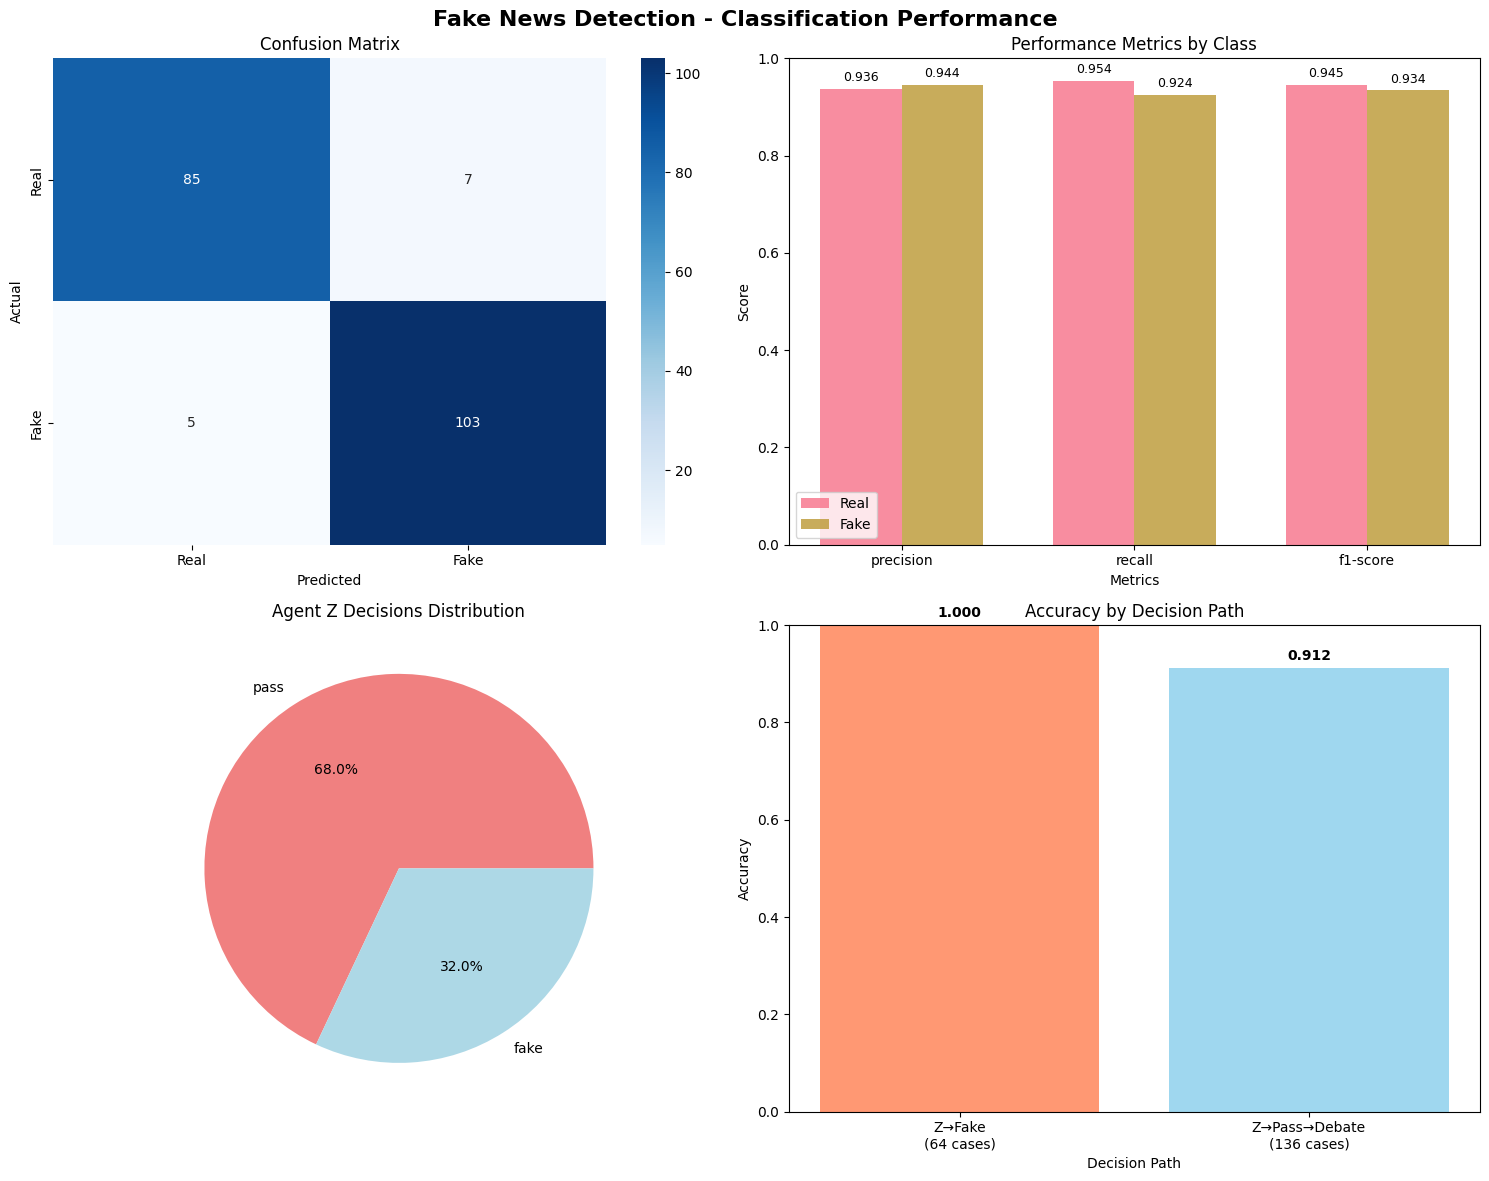

📊 Summary table saved to ./classification_summary_table.png


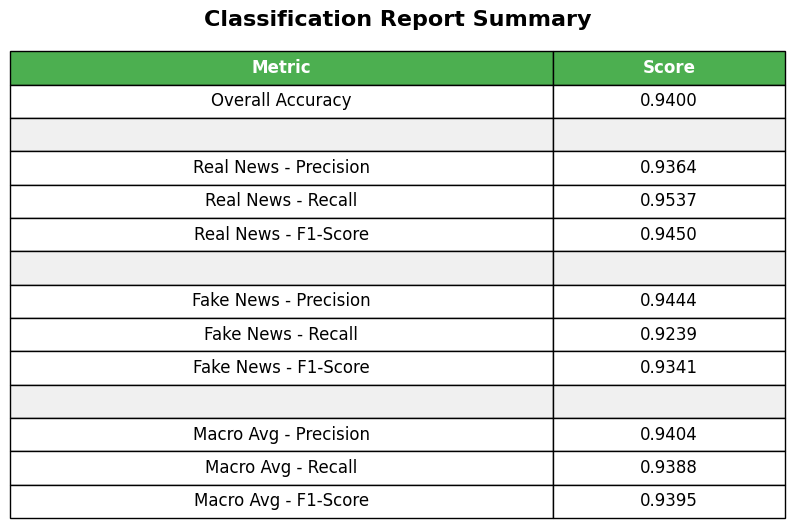


✅ CLASSIFICATION REPORT EXPORT COMPLETE!
📁 Generated files:
📋 BASIC REPORTS:
  - classification_report.csv
  - classification_report.txt
  - performance_summary.csv
📊 DETAILED ANALYSIS:
  - agent_performance_analysis.csv
  - performance_summary_detailed.json
  - performance_summary_detailed.txt
  - error_cases.csv
📈 VISUALIZATIONS:
  - classification_performance_report.png
  - classification_summary_table.png

🎯 HIGHLIGHTS:
  • performance_summary_detailed.txt: Contains formatted agent performance stats
  • agent_performance_analysis.csv: Raw data for all predictions and agent decisions
  • error_cases.csv: Detailed analysis of wrong predictions
  • Visualizations: Ready-to-use charts for presentations


In [11]:
# Cell 9: Create visualizations for classification report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def create_classification_visualizations(results_file='results.json', output_dir='./'):
    """
    Create and save various visualizations for classification performance
    """
    print("📊 Creating classification visualizations...")
    
    # Load results
    with open(results_file, 'r', encoding='utf-8') as f:
        results = json.load(f)
    
    # Prepare labels
    true_labels = []
    pred_labels = []
    
    for r in results:
        if r['predicted_label'] != "error":
            true_labels.append(r['true_label'].lower())
            pred_labels.append(r['predicted_label'].lower())
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Fake News Detection - Classification Performance', fontsize=16, fontweight='bold')
    
    # 1. Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=['real', 'fake'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], 
                yticklabels=['Real', 'Fake'], 
                ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')
    
    # 2. Classification Report Metrics
    report = classification_report(true_labels, pred_labels, 
                                 target_names=['Real', 'Fake'], 
                                 output_dict=True)
    
    metrics = ['precision', 'recall', 'f1-score']
    real_scores = [report['Real'][metric] for metric in metrics]
    fake_scores = [report['Fake'][metric] for metric in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    axes[0,1].bar(x - width/2, real_scores, width, label='Real', alpha=0.8)
    axes[0,1].bar(x + width/2, fake_scores, width, label='Fake', alpha=0.8)
    axes[0,1].set_xlabel('Metrics')
    axes[0,1].set_ylabel('Score')
    axes[0,1].set_title('Performance Metrics by Class')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(metrics)
    axes[0,1].legend()
    axes[0,1].set_ylim(0, 1)
    
    # Add value labels on bars
    for i, (real_score, fake_score) in enumerate(zip(real_scores, fake_scores)):
        axes[0,1].text(i - width/2, real_score + 0.01, f'{real_score:.3f}', 
                       ha='center', va='bottom', fontsize=9)
        axes[0,1].text(i + width/2, fake_score + 0.01, f'{fake_score:.3f}', 
                       ha='center', va='bottom', fontsize=9)
    
    # 3. Agent Performance Analysis
    analysis_data = []
    for r in results:
        if r['predicted_label'] != "error":
            z_label = r['z_output']['label']
            a_labels = [log['label'] for log in r['debate_logs'] if log['agent'] == 'A']
            b_labels = [log['label'] for log in r['debate_logs'] if log['agent'] == 'B']
            
            analysis_data.append({
                'z_decision': z_label,
                'final_correct': r['true_label'].lower() == r['predicted_label'].lower(),
                'had_debate': len(a_labels) > 0
            })
    
    analysis_df = pd.DataFrame(analysis_data)
    
    # Z Decision Distribution
    z_decisions = analysis_df['z_decision'].value_counts()
    axes[1,0].pie(z_decisions.values, labels=z_decisions.index, autopct='%1.1f%%', 
                  colors=['lightcoral', 'lightblue'])
    axes[1,0].set_title('Agent Z Decisions Distribution')
    
    # 4. Accuracy by Decision Path
    path_accuracy = []
    path_labels = []
    
    # Z says fake (no debate)
    z_fake_cases = analysis_df[analysis_df['z_decision'] == 'fake']
    if len(z_fake_cases) > 0:
        z_fake_accuracy = z_fake_cases['final_correct'].mean()
        path_accuracy.append(z_fake_accuracy)
        path_labels.append(f'Z→Fake\n({len(z_fake_cases)} cases)')
    
    # Z passes, goes to debate
    z_pass_cases = analysis_df[analysis_df['z_decision'] == 'pass']
    if len(z_pass_cases) > 0:
        z_pass_accuracy = z_pass_cases['final_correct'].mean()
        path_accuracy.append(z_pass_accuracy)
        path_labels.append(f'Z→Pass→Debate\n({len(z_pass_cases)} cases)')
    
    axes[1,1].bar(range(len(path_accuracy)), path_accuracy, 
                  color=['coral', 'skyblue'], alpha=0.8)
    axes[1,1].set_xlabel('Decision Path')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].set_title('Accuracy by Decision Path')
    axes[1,1].set_xticks(range(len(path_labels)))
    axes[1,1].set_xticklabels(path_labels)
    axes[1,1].set_ylim(0, 1)
    
    # Add value labels
    for i, acc in enumerate(path_accuracy):
        axes[1,1].text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    
    # Save the figure
    fig_file = f"{output_dir}classification_performance_report.png"
    plt.savefig(fig_file, dpi=300, bbox_inches='tight')
    print(f"📊 Visualization saved to {fig_file}")
    
    plt.show()
    
    # Create a summary table visualization
    fig2, ax = plt.subplots(figsize=(10, 6))
    ax.axis('tight')
    ax.axis('off')
    
    # Create summary table
    summary_data = [
        ['Overall Accuracy', f"{report['accuracy']:.4f}"],
        ['', ''],
        ['Real News - Precision', f"{report['Real']['precision']:.4f}"],
        ['Real News - Recall', f"{report['Real']['recall']:.4f}"],
        ['Real News - F1-Score', f"{report['Real']['f1-score']:.4f}"],
        ['', ''],
        ['Fake News - Precision', f"{report['Fake']['precision']:.4f}"],
        ['Fake News - Recall', f"{report['Fake']['recall']:.4f}"],
        ['Fake News - F1-Score', f"{report['Fake']['f1-score']:.4f}"],
        ['', ''],
        ['Macro Avg - Precision', f"{report['macro avg']['precision']:.4f}"],
        ['Macro Avg - Recall', f"{report['macro avg']['recall']:.4f}"],
        ['Macro Avg - F1-Score', f"{report['macro avg']['f1-score']:.4f}"],
    ]
    
    table = ax.table(cellText=summary_data, 
                     colLabels=['Metric', 'Score'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.7, 0.3])
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(summary_data) + 1):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            elif summary_data[i-1][0] == '':  # Empty rows
                cell.set_facecolor('#f0f0f0')
            else:
                cell.set_facecolor('#ffffff')
    
    plt.title('Classification Report Summary', fontsize=16, fontweight='bold', pad=20)
    
    # Save summary table
    table_file = f"{output_dir}classification_summary_table.png"
    plt.savefig(table_file, dpi=300, bbox_inches='tight')
    print(f"📊 Summary table saved to {table_file}")
    
    plt.show()
    
    return fig, fig2

# Create visualizations
figs = create_classification_visualizations()

print("\n✅ CLASSIFICATION REPORT EXPORT COMPLETE!")
print("📁 Generated files:")
print("📋 BASIC REPORTS:")
print("  - classification_report.csv")
print("  - classification_report.txt") 
print("  - performance_summary.csv")
print("📊 DETAILED ANALYSIS:")
print("  - agent_performance_analysis.csv")
print("  - performance_summary_detailed.json")
print("  - performance_summary_detailed.txt")
print("  - error_cases.csv")
print("📈 VISUALIZATIONS:")
print("  - classification_performance_report.png")
print("  - classification_summary_table.png")
print("\n🎯 HIGHLIGHTS:")
print("  • performance_summary_detailed.txt: Contains formatted agent performance stats")
print("  • agent_performance_analysis.csv: Raw data for all predictions and agent decisions")
print("  • error_cases.csv: Detailed analysis of wrong predictions")
print("  • Visualizations: Ready-to-use charts for presentations")
